## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import log_loss, f1_score, roc_curve, auc, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import lightgbm as lgb
import optuna

## Set file paths for train and predict datasets

In [2]:
train_dataset = "Dataset/Train.csv"
predict_dataset = "Dataset/Test.csv"

## Exploratory Data Analysis

#### Get train dataset info

In [61]:
train_df = pd.read_csv(train_dataset)
train_df.head()

,City,Location_Score,Internal_Audit_Score,External_Audit_Score,Fin_Score,Loss_score,Past_Results,IsUnderRisk
0,2,8.032,14,8,3,6,0,1
1,31,77.730,8,3,3,8,1,0
2,40,59.203,3,12,11,3,0,1
3,12,73.080,4,5,7,6,0,0
4,4,15.666,13,15,6,7,2,1


In [62]:
train_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543 entries, 0 to 542
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   City                  543 non-null    int64  
 1   Location_Score        543 non-null    float64
 2   Internal_Audit_Score  543 non-null    int64  
 3   External_Audit_Score  543 non-null    int64  
 4   Fin_Score             543 non-null    int64  
 5   Loss_score            543 non-null    int64  
 6   Past_Results          543 non-null    int64  
 7   IsUnderRisk           543 non-null    int64  
dtypes: float64(1), int64(7)
memory usage: 34.1 KB


#### Get predict dataset info

In [ ]:
predict_df = pd.read_csv(predict_dataset)
predict_df.head()

In [ ]:
predict_df.info(verbose=True)

#### Count plot of target variable

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x="IsUnderRisk", data=train_df).set_title('Count plot of "IsUnderRisk" data')
plt.grid()

#### Examine class imbalance

In [ ]:
neg, pos = np.bincount(train_df['IsUnderRisk'])
total = neg + pos
print('Total: {}\n  Positive: {} ({:.2f}% of total)\n  Negative: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total, neg, 100 * neg / total))

#### Get correlation between different features

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(train_df.corr(), annot=True, linewidth = 0.5, cmap='coolwarm')
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
sns.set(style="ticks", color_codes=True)
sns.pairplot(train_df)
plt.show()

In [ ]:
# Plot distribution of data in "Location_Score" field
fig, ax = plt.subplots(figsize = (15, 6))
plt.subplot(1, 2, 1)
sns.distplot(train_df['Location_Score'])
plt.title('Distribution of Location_Score data');
plt.subplot(1, 2, 2)
sns.distplot(np.log1p(train_df['Location_Score']))
plt.title('Distribution of log of Location_Score data');

In [ ]:
# Plot distribution of data in "Fin_Score" field
fig, ax = plt.subplots(figsize = (15, 6))
plt.subplot(1, 2, 1)
sns.distplot(train_df['Fin_Score'])
plt.title('Distribution of Fin_Score data');
plt.subplot(1, 2, 2)
sns.distplot(np.log1p(train_df['Fin_Score']))
plt.title('Distribution of log of Fin_Score data');

In [ ]:
# Plot distribution of data in "Loss_score" field
fig, ax = plt.subplots(figsize = (15, 6))
plt.subplot(1, 2, 1)
sns.distplot(train_df['Loss_score'])
plt.title('Distribution of Loss_score data');
plt.subplot(1, 2, 2)
sns.distplot(np.log1p(train_df['Loss_score']))
plt.title('Distribution of log of Loss_score data');

In [ ]:
# Plot distribution of data in "Past_Results" field
fig, ax = plt.subplots(figsize = (15, 6))
plt.subplot(1, 2, 1)
sns.distplot(train_df['Past_Results'])
plt.title('Distribution of Past_Results data');
plt.subplot(1, 2, 2)
sns.distplot(np.log1p(train_df['Past_Results']))
plt.title('Distribution of log of Past_Results data');

## Data Preprocessing

#### Read train and predict datasets

In [64]:
train_df = pd.read_csv(train_dataset)
predict_df = pd.read_csv(predict_dataset)
print("train_df: {}".format(train_df.shape))
print("predict_df: {}".format(predict_df.shape))

train_df: (543, 8)
predict_df: (233, 7)


#### Extract "IsUnderRisk" field from train_df into NumPy array

In [65]:
train_y = np.array([train_df['IsUnderRisk'].values]).T
train_df.drop(['IsUnderRisk'], inplace=True, axis=1)
print("train_y: {}".format(train_y.shape))

train_y: (543, 1)


#### Feature Engineering

In [66]:
# Combine train and predict dataframes
combined_df = train_df.append(predict_df, sort=False, ignore_index=True)
print(combined_df.shape)

(776, 7)


In [67]:
# Convert "City" to one-hot encoding
one_hot = pd.get_dummies(combined_df['City'])
combined_df.drop('City', axis = 1, inplace=True)
combined_df = combined_df.join(one_hot)
combined_df.head()

,Location_Score,Internal_Audit_Score,External_Audit_Score,Fin_Score,Loss_score,Past_Results,0,1,2,3,...,35,36,37,38,39,40,41,42,43,44
0,8.032,14,8,3,6,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,77.730,8,3,3,8,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,59.203,3,12,11,3,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,73.080,4,5,7,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,15.666,13,15,6,7,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
combined_df["Location_Score"] = np.log1p(combined_df["Location_Score"])
combined_df["Fin_Score"] = np.log1p(combined_df["Fin_Score"])
combined_df["Loss_score"] = np.log1p(combined_df["Loss_score"])
combined_df["Past_Results"] = np.log1p(combined_df["Past_Results"])

In [69]:
combined_df["Fin_Score/Internal_Audit_Score"] = combined_df["Fin_Score"] / combined_df["Internal_Audit_Score"]
combined_df["Fin_Score/External_Audit_Score"] = combined_df["Fin_Score"] / combined_df["External_Audit_Score"]
combined_df["Fin_Score/(IAS + EAS)"] = combined_df["Fin_Score"] / (combined_df["Internal_Audit_Score"] + combined_df["External_Audit_Score"])

In [70]:
combined_df["Loss_score/Internal_Audit_Score"] = combined_df["Loss_score"] / combined_df["Internal_Audit_Score"]
combined_df["Loss_score/External_Audit_Score"] = combined_df["Loss_score"] / combined_df["External_Audit_Score"]
combined_df["Loss_score/(IAS + EAS)"] = combined_df["Loss_score"] / (combined_df["Internal_Audit_Score"] + combined_df["External_Audit_Score"])
combined_df["Loss_score/Fin_Score"] = combined_df["Loss_score"] / combined_df["Fin_Score"]

In [71]:
combined_df["Fin_Score/Location_Score"] = combined_df["Fin_Score"] / combined_df["Location_Score"]
combined_df["Loss_score/Location_Score"] = combined_df["Loss_score"] / combined_df["Location_Score"]
combined_df["Internal_Audit_Score/Location_Score"] = combined_df["Internal_Audit_Score"] / combined_df["Location_Score"]
combined_df["External_Audit_Score/Location_Score"] = combined_df["External_Audit_Score"] / combined_df["Location_Score"]
combined_df["(IAS + EAS)/Location_Score"] = (combined_df["Internal_Audit_Score"] + combined_df["External_Audit_Score"]) / combined_df["Location_Score"]

#### Create train and predict Numpy arrays and scale them

In [72]:
# Segregate combined_df into train/predict datasets
train_x = combined_df[:543]
predict_x = combined_df[543:]

print("train_x: {}".format(train_x.shape))
print("predict_x: {}".format(predict_x.shape))

train_x: (543, 63)
predict_x: (233, 63)


In [73]:
# Scale the train_x/predict_x arrays
scaler = MinMaxScaler().fit(train_x)
train_x = scaler.transform(train_x)
predict_x = scaler.transform(predict_x)

In [12]:
train_x_full = train_x.copy()
train_y_full = train_y.copy()

#### Oversampling entire data to handle class imbalance

In [74]:
sm = SMOTE()
sm_x, sm_y = sm.fit_sample(train_x, train_y.ravel())
train_x_full = sm_x
train_y_full = np.array([sm_y]).T
print("Class balancing done.")
print("train_x_full shape: {}".format(train_x_full.shape))
print("train_y_full shape: {}".format(train_y_full.shape))

Class balancing done.
train_x_full shape: (680, 63)
train_y_full shape: (680, 1)


#### Split training data into train/test datasets

In [75]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.075, random_state=1)
for train_index, test_index in sss.split(train_x, train_y):
    train_x, test_x = train_x[train_index], train_x[test_index]
    train_y, test_y = train_y[train_index], train_y[test_index]

print("------------------------- Training Dataset -------------------------")
print("train_x shape: {}".format(train_x.shape))
print("train_y shape: {}".format(train_y.shape))

print("\n------------------------- Test Dataset -------------------------")
print("test_x shape: {}".format(test_x.shape))
print("test_y shape: {}".format(test_y.shape))

------------------------- Training Dataset -------------------------
train_x shape: (502, 63)
train_y shape: (502, 1)

------------------------- Test Dataset -------------------------
test_x shape: (41, 63)
test_y shape: (41, 1)


#### Oversampling splitted data to handle class imbalance

In [76]:
sm = SMOTE()
sm_x, sm_y = sm.fit_sample(train_x, train_y.ravel())
train_x = sm_x
train_y = np.array([sm_y]).T
print("Class balancing done.")
print("train_x shape: {}".format(train_x.shape))
print("train_y shape: {}".format(train_y.shape))

Class balancing done.
train_x shape: (628, 63)
train_y shape: (628, 1)


In [77]:
Xtrain_full, Ytrain_full = train_x_full.copy(), train_y_full.copy()
Xtrain, Ytrain = train_x.copy(), train_y.copy()
Xtest, Ytest = test_x.copy(), test_y.copy()
Xpredict = predict_x.copy()

print("------------------------- Training Dataset -------------------------")
print("Xtrain_full shape: {}".format(Xtrain_full.shape))
print("Ytrain_full shape: {}".format(Ytrain_full.shape))
print("Xtrain shape: {}".format(Xtrain.shape))
print("Ytrain shape: {}".format(Ytrain.shape))

print("\n------------------------- Test Dataset -------------------------")
print("Xtest shape: {}".format(Xtest.shape))
print("Ytest shape: {}".format(Ytest.shape))

print("\n------------------------- Prediction Dataset -------------------------")
print("Xpredict shape: {}".format(Xpredict.shape))

------------------------- Training Dataset -------------------------
Xtrain_full shape: (680, 63)
Ytrain_full shape: (680, 1)
Xtrain shape: (628, 63)
Ytrain shape: (628, 1)

------------------------- Test Dataset -------------------------
Xtest shape: (41, 63)
Ytest shape: (41, 1)

------------------------- Prediction Dataset -------------------------
Xpredict shape: (233, 63)


## Hyperparameter search using Optuna

In [78]:
# Convert Ytest to one-hot encoding
df = pd.DataFrame(Ytest, columns=["IsUnderRisk"])
test_y = pd.get_dummies(df['IsUnderRisk']).values

In [79]:
# Define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

In [80]:
def objective(trial):
    
    params = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "num_class": 2,
        "verbosity": -1,
        "boosting_type": "gbdt",
        #"is_unbalance": True,
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-2, 1e-1),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-4, 1.0),
        "num_leaves": trial.suggest_int("num_leaves", 31, 150),
        "max_depth": trial.suggest_int("max_depth", 7, 20),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 5, 20),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 20),
    }
    
    y_pred = 0
    counter = 0
    for train, val in kfold.split(Xtrain, Ytrain):
        counter += 1
    
        train_x, train_y = Xtrain[train], Ytrain[train]
        val_x, val_y = Xtrain[val], Ytrain[val]

        lgtrain = lgb.Dataset(train_x, label=train_y.ravel())
        lgvalidation = lgb.Dataset(val_x, label=val_y.ravel())

        model = lgb.train(params, lgtrain, valid_sets=[lgvalidation], 
                          num_boost_round=5000, early_stopping_rounds=200, verbose_eval=False)
        pred = model.predict(Xtest, num_iteration=model.best_iteration)

        y_pred += pred

    y_pred /= float(counter)
    loss = log_loss(test_y, y_pred)
    score = 100 * max(0, 1 - loss)

    return score

In [81]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2020-05-16 03:59:09,979] Finished trial#0 with value: 71.13105546359748 with parameters: {'learning_rate': 0.013407357857925243, 'lambda_l2': 0.914350214723398, 'num_leaves': 72, 'max_depth': 16, 'feature_fraction': 0.7351086519011277, 'bagging_fraction': 0.6683241147401016, 'bagging_freq': 9, 'min_child_samples': 16}. Best is trial#0 with value: 71.13105546359748.
[I 2020-05-16 03:59:13,754] Finished trial#1 with value: 74.3063159476433 with parameters: {'learning_rate': 0.051863150799241454, 'lambda_l2': 0.0469096706022759, 'num_leaves': 59, 'max_depth': 14, 'feature_fraction': 0.9067223332982696, 'bagging_fraction': 0.573852449190348, 'bagging_freq': 20, 'min_child_samples': 9}. Best is trial#1 with value: 74.3063159476433.
[I 2020-05-16 03:59:18,715] Finished trial#2 with value: 72.17338500303762 with parameters: {'learning_rate': 0.033039231130903485, 'lambda_l2': 0.00011786908787263417, 'num_leaves': 126, 'max_depth': 13, 'feature_fraction': 0.7172874306339815, 'bagging_fracti

[I 2020-05-16 04:02:19,789] Finished trial#21 with value: 78.4224276924284 with parameters: {'learning_rate': 0.017305170709227505, 'lambda_l2': 0.00041710114088464246, 'num_leaves': 73, 'max_depth': 13, 'feature_fraction': 0.7762128286609967, 'bagging_fraction': 0.9502944965843153, 'bagging_freq': 7, 'min_child_samples': 3}. Best is trial#20 with value: 78.68764562409265.
[I 2020-05-16 04:02:30,765] Finished trial#22 with value: 77.46277597794537 with parameters: {'learning_rate': 0.016893966912123297, 'lambda_l2': 0.000288714874797408, 'num_leaves': 65, 'max_depth': 14, 'feature_fraction': 0.8403098828279691, 'bagging_fraction': 0.938150605754197, 'bagging_freq': 7, 'min_child_samples': 7}. Best is trial#20 with value: 78.68764562409265.
[I 2020-05-16 04:02:37,550] Finished trial#23 with value: 78.08093342856284 with parameters: {'learning_rate': 0.09913048472244428, 'lambda_l2': 0.003300142669913489, 'num_leaves': 81, 'max_depth': 12, 'feature_fraction': 0.7847705101957083, 'bagging

[I 2020-05-16 04:06:19,001] Finished trial#42 with value: 77.79855799989419 with parameters: {'learning_rate': 0.057142287829916025, 'lambda_l2': 0.0002490910114033653, 'num_leaves': 39, 'max_depth': 17, 'feature_fraction': 0.8616725614174671, 'bagging_fraction': 0.8025731178791365, 'bagging_freq': 13, 'min_child_samples': 1}. Best is trial#37 with value: 79.90079737305103.
[I 2020-05-16 04:06:27,444] Finished trial#43 with value: 78.73623535534446 with parameters: {'learning_rate': 0.030659061169798624, 'lambda_l2': 0.0010133431716026367, 'num_leaves': 32, 'max_depth': 15, 'feature_fraction': 0.938199326957396, 'bagging_fraction': 0.8476315860615532, 'bagging_freq': 10, 'min_child_samples': 4}. Best is trial#37 with value: 79.90079737305103.
[I 2020-05-16 04:06:39,581] Finished trial#44 with value: 81.07589799624549 with parameters: {'learning_rate': 0.03460233605744106, 'lambda_l2': 0.0007036947533245635, 'num_leaves': 58, 'max_depth': 16, 'feature_fraction': 0.8894252479204888, 'bag

[I 2020-05-16 04:09:46,598] Finished trial#63 with value: 77.1997187464017 with parameters: {'learning_rate': 0.03213462439235406, 'lambda_l2': 0.0032102037333060105, 'num_leaves': 34, 'max_depth': 18, 'feature_fraction': 0.8752586255041201, 'bagging_fraction': 0.7341763069185949, 'bagging_freq': 14, 'min_child_samples': 2}. Best is trial#44 with value: 81.07589799624549.
[I 2020-05-16 04:09:55,546] Finished trial#64 with value: 79.52228916671655 with parameters: {'learning_rate': 0.04724145171219845, 'lambda_l2': 0.0052077103322140115, 'num_leaves': 40, 'max_depth': 12, 'feature_fraction': 0.9706574538773107, 'bagging_fraction': 0.7093241063402042, 'bagging_freq': 15, 'min_child_samples': 3}. Best is trial#44 with value: 81.07589799624549.
[I 2020-05-16 04:10:04,241] Finished trial#65 with value: 80.36452680511495 with parameters: {'learning_rate': 0.046226895935234456, 'lambda_l2': 0.009887194027560482, 'num_leaves': 40, 'max_depth': 12, 'feature_fraction': 0.9734960670931445, 'baggi

[I 2020-05-16 04:12:54,601] Finished trial#84 with value: 78.24413229634135 with parameters: {'learning_rate': 0.051493382452816386, 'lambda_l2': 0.000952698577067005, 'num_leaves': 47, 'max_depth': 15, 'feature_fraction': 0.8106045618669774, 'bagging_fraction': 0.8262130396903616, 'bagging_freq': 9, 'min_child_samples': 3}. Best is trial#44 with value: 81.07589799624549.
[I 2020-05-16 04:13:07,882] Finished trial#85 with value: 79.76572272127027 with parameters: {'learning_rate': 0.0436353975288565, 'lambda_l2': 0.0003820821550777627, 'num_leaves': 63, 'max_depth': 14, 'feature_fraction': 0.9914105391122136, 'bagging_fraction': 0.7981441155257295, 'bagging_freq': 10, 'min_child_samples': 1}. Best is trial#44 with value: 81.07589799624549.
[I 2020-05-16 04:13:20,991] Finished trial#86 with value: 80.39013817016107 with parameters: {'learning_rate': 0.042798513761126165, 'lambda_l2': 0.00024047736307427112, 'num_leaves': 63, 'max_depth': 14, 'feature_fraction': 0.8964196868531065, 'bagg

In [82]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("Value: {}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
Value: 81.07589799624549
Params: 
 learning_rate: 0.03460233605744106
 lambda_l2: 0.0007036947533245635
 num_leaves: 58
 max_depth: 16
 feature_fraction: 0.8894252479204888
 bagging_fraction: 0.7664114125840714
 bagging_freq: 11
 min_child_samples: 2


## Build the model

In [83]:
# Define model hyperparameters
params = {}
params["objective"] = 'multiclass'
params["metric"] = 'multi_logloss'
params["num_class"] = 2
#params["is_unbalance"] = True
params["boosting"] = 'gbdt'
params["max_depth"] = 16
params["num_leaves"] = 58
params["learning_rate"] = 0.0346
params["bagging_fraction"] = 0.77
params["feature_fraction"] = 0.89
params["bagging_freq"] = 11
params["bagging_seed"] = 10
params["lambda_l2"] = 0.001
params["min_data_in_leaf"] = 2
params["verbosity"] = -1
num_rounds = 5000

In [84]:
# Define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
y_pred = 0

In [85]:
# Train the model using K-fold
counter = 0

for train, val in kfold.split(Xtrain, Ytrain):
    counter += 1

    train_x, train_y = Xtrain[train], Ytrain[train]
    val_x, val_y = Xtrain[val], Ytrain[val]

    lgtrain = lgb.Dataset(train_x, label=train_y.ravel())
    lgvalidation = lgb.Dataset(val_x, label=val_y.ravel())

    model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgvalidation], early_stopping_rounds=200, verbose_eval=1000)
    pred = model.predict(Xtest, num_iteration=model.best_iteration)

    y_pred += pred

y_pred /= float(counter)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.287752
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[101]	valid_0's multi_logloss: 0.273368
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.273067
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 0.295476
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[91]	valid_0's multi_logloss: 0.272747


## Validate the model

In [86]:
#Print log_loss
loss = log_loss(test_y, y_pred)
print('Overall log_loss of model:', loss)

Overall log_loss of model: 0.22499325690763275


In [87]:
#Print accuracy
y_pred_binary = np.array([np.argmax(y_pred, axis=1)]).T
acc_score = accuracy_score(Ytest, y_pred_binary)
print('Overall accuracy of ANN model:', acc_score)

Overall accuracy of ANN model: 0.926829268292683


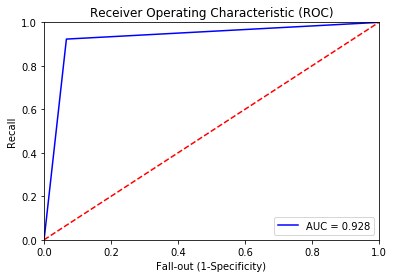

AUC score: 0.9282051282051282


In [88]:
#Print Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(Ytest, y_pred_binary)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

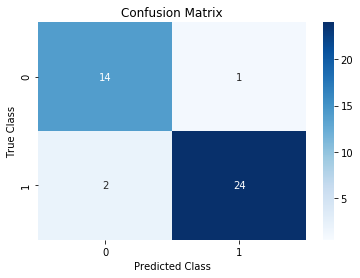

In [89]:
#Print Confusion Matrix
cm = confusion_matrix(Ytest, y_pred_binary)
labels = ['0', '1']
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.5);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

## Train model on entire data

In [90]:
# Define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
y_pred = 0

In [91]:
# Train the model using K-fold
counter = 0

for train, val in kfold.split(Xtrain_full, Ytrain_full):
    counter += 1

    train_x, train_y = Xtrain_full[train], Ytrain_full[train]
    val_x, val_y = Xtrain_full[val], Ytrain_full[val]

    lgtrain = lgb.Dataset(train_x, label=train_y.ravel())
    lgvalidation = lgb.Dataset(val_x, label=val_y.ravel())

    model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgvalidation], early_stopping_rounds=200, verbose_eval=1000)
    pred = model.predict(Xpredict, num_iteration=model.best_iteration)

    y_pred += pred

y_pred /= float(counter)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[66]	valid_0's multi_logloss: 0.356494
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[85]	valid_0's multi_logloss: 0.296339
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.279196
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[110]	valid_0's multi_logloss: 0.169961
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.273137


## Create submission file

In [92]:
submit_df = pd.DataFrame(y_pred, columns=['0','1'])
submit_df.head()

,0,1
0,0.035290,0.964710
1,0.215446,0.784554
2,0.544866,0.455134
3,0.035290,0.964710
4,0.151149,0.848851


In [93]:
submit_df.to_excel("Predictions/predictions_v4.xlsx", index=False)